In [1]:
# === Imports ===
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

In [2]:
# === Paths ===
input_dir = r"C:\Users\Virika\Downloads\kvpc\prostrate_cancer_data"
output_dir = r"C:\Users\Virika\Downloads\kvpc\preprocessed_data"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# === Label Mapping ===
label_map = {'GG0': 0, 'GG1': 1, 'GG2': 1, 'GG3': 1, 'GG4': 1, 'GG5': 1}

# === Helper: CLAHE ===
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

In [11]:
# === Preprocessing Function ===
def preprocess_and_save():
    all_images = []
    skipped_images = []

    for grade_folder in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, grade_folder)
        if not os.path.isdir(folder_path):
            continue

        label = label_map.get(grade_folder, 1)

        for img_path in tqdm(glob(os.path.join(folder_path, "*.jpg")), desc=f"Processing {grade_folder}"):
            img = cv2.imread(img_path)

            if img is None:
                print(f"[Warning] Skipped unreadable image: {img_path}")
                skipped_images.append(img_path)
                continue

            try:
                img = cv2.resize(img, (224, 224))
                img = apply_clahe(img)
                img = img.astype(np.float32)
                img = (img - np.mean(img)) / (np.std(img) + 1e-8)
                img_name = Path(img_path).stem
                save_path = os.path.join(output_dir, f"{grade_folder}_{img_name}.npy")
                np.save(save_path, img)
                all_images.append((save_path, label))
            except Exception as e:
                print(f"[Error] Failed processing {img_path}: {e}")
                skipped_images.append(img_path)

    print(f"\n✅ Completed preprocessing. Total processed: {len(all_images)}, Skipped: {len(skipped_images)}")
    return all_images


# === Run Preprocessing ===
all_data = preprocess_and_save()

Processing GG0:   0%|          | 0/100 [00:00<?, ?it/s]

Processing GG5: 100%|██████████| 100/100 [00:01<00:00, 61.35it/s]


✅ Completed preprocessing. Total processed: 600, Skipped: 0


In [5]:
# === Split Dataset ===
df = pd.DataFrame(all_data, columns=["path", "label"])
train_val, test = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, stratify=train_val["label"], random_state=42)
train.to_csv("train_split.csv", index=False)
val.to_csv("val_split.csv", index=False)
test.to_csv("test_split.csv", index=False)


In [6]:
# === Dataset Class ===
class HistopathologyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = np.load(self.df.iloc[idx]["path"])
        label = self.df.iloc[idx]["label"]
        img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

In [7]:

# === Transforms ===
train_tfms = transforms.Compose([
    transforms.ToTensor()
])
# === Loaders ===
train_ds = HistopathologyDataset("train_split.csv", transform=train_tfms)
val_ds = HistopathologyDataset("val_split.csv", transform=train_tfms)
test_ds = HistopathologyDataset("test_split.csv", transform=train_tfms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)


In [8]:
import torch
import torch.nn as nn
import timm

class SwinBinaryClassifier(nn.Module):
    def __init__(self, model_name="swin_tiny_patch4_window7_224"):
        super(SwinBinaryClassifier, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, 1)  # Binary classification (output logits)

    def forward(self, x):
        return self.backbone(x)

model = SwinBinaryClassifier()


In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# === Assuming model, train_loader, device are already defined ===

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Store loss values
train_losses = []

# === Training Loop ===
for epoch in range(10):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Ensure labels shape: [batch_size, 1]

        optimizer.zero_grad()
        outputs = model(images)

        # Reshape outputs to [batch_size, 1] if not already
        if outputs.dim() > 2:
            outputs = outputs.view(outputs.size(0), -1).mean(dim=1, keepdim=True)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

# === Plotting the Loss Curve ===
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='teal')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:  # replace with val_loader if you have one
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        
        # Reshape and apply sigmoid
        if outputs.dim() > 2:
            outputs = outputs.view(outputs.size(0), -1).mean(dim=1, keepdim=True)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Flatten lists
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f"\n=== Evaluation Metrics ===")
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"Confusion Matrix:\n{cm}")



=== Evaluation Metrics ===
Accuracy      : 0.9642
Precision     : 0.9588
Recall        : 1.0000
F1 Score      : 0.9790
Confusion Matrix:
[[ 55  15]
 [  0 349]]


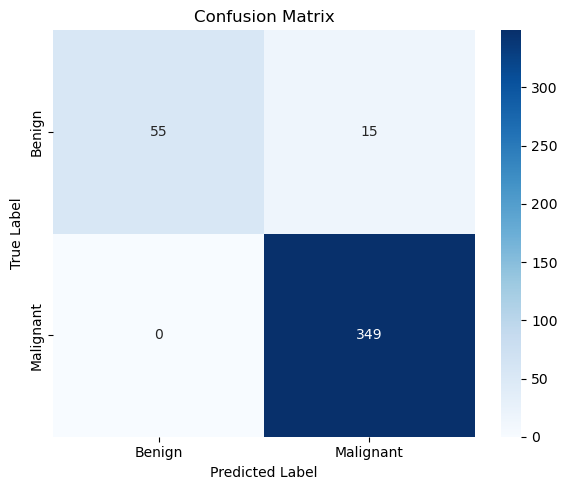

C:\Users\Virika\AppData\Local\Temp\ipykernel_10364\1407879895.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="pastel")


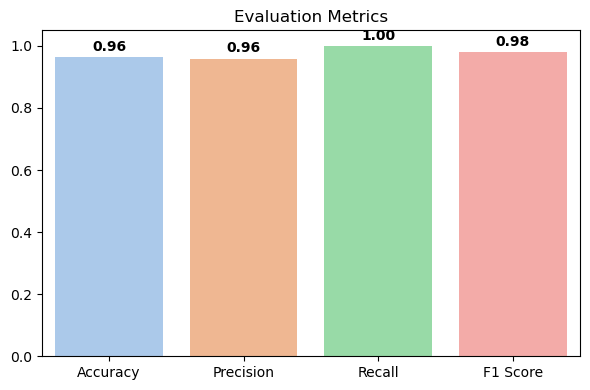

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Accuracy Bar Graph ===
plt.figure(figsize=(6, 4))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [acc, prec, rec, f1]
sns.barplot(x=metrics, y=values, palette="pastel")
plt.ylim(0, 1.05)
plt.title("Evaluation Metrics")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

=== Confusion Matrix ===
[[ 1 14]
 [ 0 75]]

=== Classification Report ===
              precision    recall  f1-score   support

         0.0     1.0000    0.0667    0.1250        15
         1.0     0.8427    1.0000    0.9146        75

    accuracy                         0.8444        90
   macro avg     0.9213    0.5333    0.5198        90
weighted avg     0.8689    0.8444    0.7830        90

ROC AUC: 0.7591


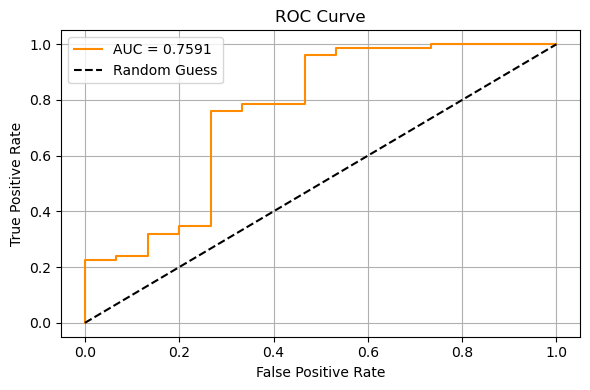

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)

            # Fix for 4D outputs like [B, C, H, W]
            if outputs.dim() > 2:
                outputs = outputs.view(outputs.size(0), -1).mean(dim=1, keepdim=True)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Convert to flat arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_scores = np.array(y_scores).flatten()

    # Print Metrics
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_true, y_pred))
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_true, y_scores):.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# === Run Evaluation ===
evaluate(model, test_loader)


In [ ]:
import cv2
import matplotlib.pyplot as plt

# === Denoising Function ===
def denoise_image(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

# === Cancer Region Detection & Visualization ===
def detect_and_visualize_cancer(img_path):
    # Load original preprocessed image
    original = np.load(img_path)
    img = (original * 255).astype(np.uint8) if original.max() <= 1 else original.astype(np.uint8)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Denoise
    denoised = denoise_image(img_bgr)

    # Convert to grayscale for thresholding
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to isolate potential cancer regions
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a copy of the original image
    contour_img = denoised.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 1)

    # Plot all images
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Denoised Image")
    axes[1].axis("off")

    axes[2].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Cancer Region with Boundaries")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


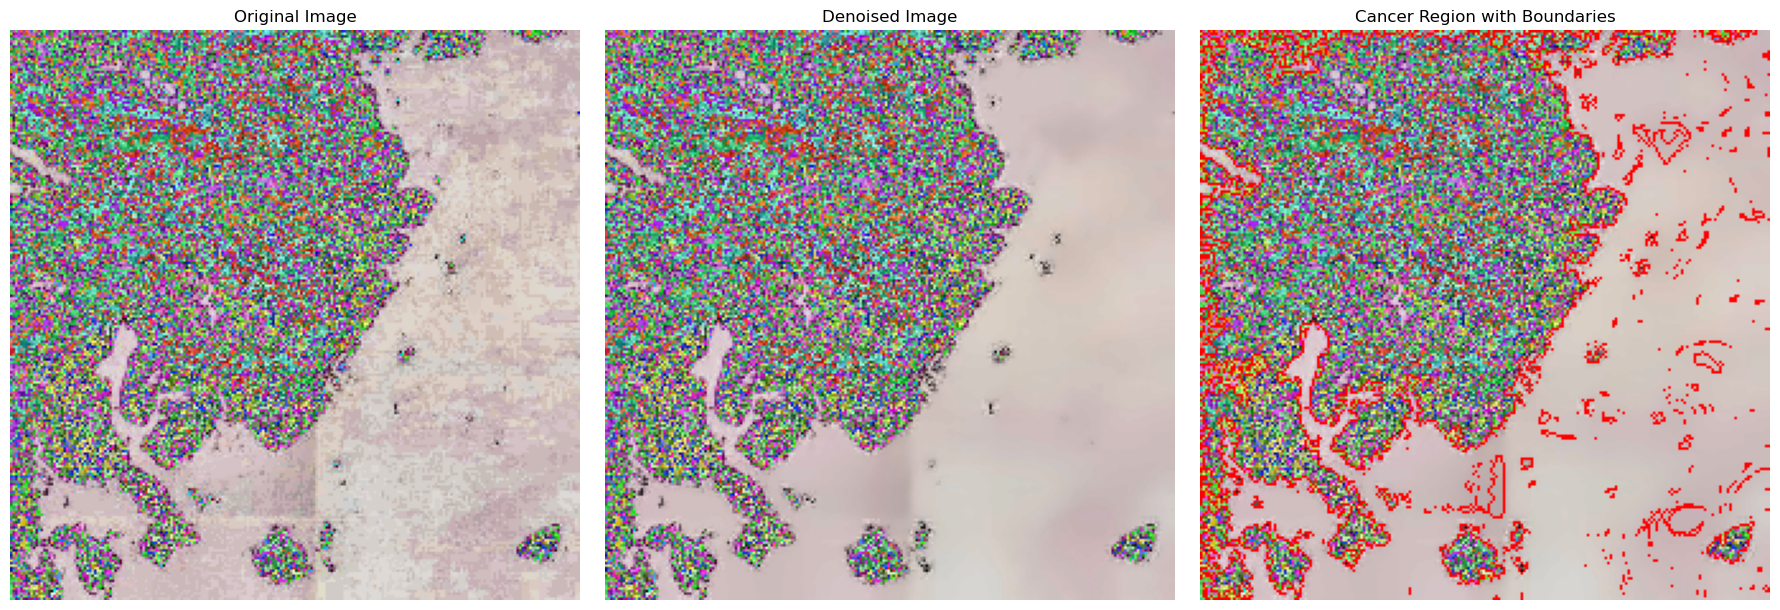

In [ ]:
# Pick a sample positive image from test set
test_df = pd.read_csv("test_split.csv")
positive_imgs = test_df[test_df["label"] == 1]["path"].values

# Visualize a random one
import random
sample_img = random.choice(positive_imgs)
detect_and_visualize_cancer(sample_img)


In [ ]:
# === Updated Path to Your Dataset Folder ===
data_folder = r"C:\Users\Virika\Downloads\kvpc\preprocessed_data"
image_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

# === Main Visualization Function (unchanged except path input) ===
def process_and_display(image_path):
    img = np.load(image_path)
    img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Preprocessing
    denoised, detected = detect_cancer_region(img_bgr)

    # Model prediction
    model.eval()
    with torch.no_grad():
        tensor_img = transforms.ToTensor()(img).unsqueeze(0).to(device)
        logits = model(tensor_img)
        if logits.dim() > 2:
            logits = logits.view(logits.size(0), -1).mean(dim=1, keepdim=True)
        prob = torch.sigmoid(logits).item()
        label = "Malignant" if prob > 0.5 else "Benign"
        confidence = f"{prob * 100:.2f}%"

    # Return visualizations + prediction
    return (
        cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(detected, cv2.COLOR_BGR2RGB),
        f"Prediction: **{label}**\nConfidence: {confidence}"
    )

# === Gradio UI ===
dropdown = gr.Dropdown(choices=image_files, label="Select Image from Preprocessed Dataset")

gr.Interface(
    fn=process_and_display,
    inputs=dropdown,
    outputs=[
        gr.Image(label="Original Image"),
        gr.Image(label="Denoised Image"),
        gr.Image(label="Cancer Region Highlighted"),
        gr.Markdown(label="Prediction Result")
    ],
    title="Prostate Cancer Detection",
    description="Select an image to see cancer prediction, denoising, and highlighted region.",
).launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import gradio as gr
import numpy as np

def plot_confusion_matrix(true_labels, pred_labels):
    # If uploaded as .npy files
    if isinstance(true_labels, str):  # file path
        true_labels = np.load(true_labels)
    if isinstance(pred_labels, str):
        pred_labels = np.load(pred_labels)

    cm = confusion_matrix(true_labels, pred_labels)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["Benign", "Malignant"],
                yticklabels=["Benign", "Malignant"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    return fig

# Interface for live confusion matrix
gr.Interface(
    fn=plot_confusion_matrix,
    inputs=[
        gr.File(label="True Labels (.npy)"),
        gr.File(label="Predicted Labels (.npy)")
    ],
    outputs=gr.Plot(label="Confusion Matrix Heatmap"),
    title="View Model Confusion Matrix",
    description="Upload true and predicted labels to visualize model weaknesses.",
).launch()


# just a note---this part of code Helps doctors/researchers see model weaknesses (e.g., false negatives).

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
